In [1]:
import numpy as np
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot
import pandas as pd
import plotly.graph_objects as go

In [2]:
###################
# generate sample #
def generate_samples(path, path_sensor):
    X = pd.read_csv(path_sensor, skiprows=1)
    y = pd.read_csv(path)
    df = pd.concat([X, y], axis=1)
    return df

def generate_samples_GAN(path_sensor, half_batch):
    X = pd.read_csv(path_sensor, skiprows=1, )
    y = pd.DataFrame(np.ones((X.size, 1)))
    # generate numpy arrays
    X.to_numpy
    y.to_numpy
    X = np.transpose(X)
    y = np.transpose(y)
    return X, y

#############
# load data #
#path = '../data/Exercises_SS22/sleeplab_dataset_10hz/patient_29_male_7_years/sleep_staging.csv'
#path_sensor = '../data/Exercises_SS22/sleeplab_dataset_10hz/patient_29_male_7_years/BeinLI_10HZ.csv'

#df = generate_samples(path, path_sensor)
#X, y = generate_samples_GAN(path_sensor, 128)

#print(X.head())
#print(y.head())


In [3]:
################
# plot samples #
'''fig = go.Figure(data=go.Scatter(
    y = df_GAN['data'],
    mode='lines',
    marker=dict(
        size=16,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))

fig.add_trace(go.Scatter(
    y = df_GAN['0'],
    mode='lines',
    marker=dict(
        size=16,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.show()'''

"fig = go.Figure(data=go.Scatter(\n    y = df_GAN['data'],\n    mode='lines',\n    marker=dict(\n        size=16,\n        color=np.random.randn(500), #set color equal to a variable\n        colorscale='Viridis', # one of plotly colorscales\n        showscale=True\n    )))\n\nfig.add_trace(go.Scatter(\n    y = df_GAN['0'],\n    mode='lines',\n    marker=dict(\n        size=16,\n        color=np.random.randn(500), #set color equal to a variable\n        colorscale='Viridis', # one of plotly colorscales\n        showscale=True\n    )\n))\n\nfig.show()"

In [4]:
from keras import backend
 
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                8182750   
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8,182,776
Trainable params: 8,182,776
Non-trainable params: 0
_________________________________________________________________


2022-06-29 14:04:45.470711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 14:04:45.470814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


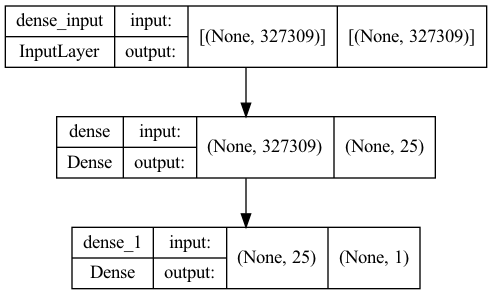

In [5]:
# define the discriminator model
# because of WGAN activation is linear!
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(n_inputs=327309):
    model = Sequential()
    model.add(Dense(25, activation='linear', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='linear'))
    # compile model
    model.compile(loss=wasserstein_loss, optimizer='adam', metrics=['accuracy'])
    return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                90        
                                                                 
 dense_3 (Dense)             (None, 327309)            5236944   
                                                                 
Total params: 5,237,034
Trainable params: 5,237,034
Non-trainable params: 0
_________________________________________________________________


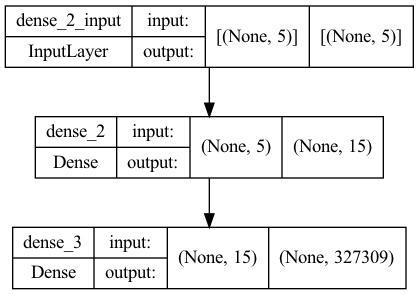

In [6]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=327309):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss=wasserstein_loss, optimizer='adam')
    return model

In [8]:
from numpy.random import rand
from numpy.random import randn
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

In [10]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, path_sensor, n=100):
    # prepare real samples
    x_real, y_real = generate_samples_GAN(path_sensor, n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('Epoch:', epoch, 'acc_real:', acc_real, 'acc_fake:', acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, path_sensor, n_epochs=100, n_batch=128, n_eval=5):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_samples_GAN(path_sensor, half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        #print(x_real, y_real)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim, path_sensor)
            # list all data in history
            #print(history.history.keys())

In [12]:
from numpy import zeros
from numpy import ones

# size of the latent space
latent_dim = 5
# path to real data
path_sensor = '../data/Exercises_SS22/sleeplab_dataset_10hz/patient_29_male_7_years/BeinLI_10HZ.csv'
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, path_sensor)

2022-06-29 14:04:46.135165: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-29 14:04:46.166286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-29 14:04:46.373797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-29 14:04:46.529935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-29 14:04:46.795892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-29 14:04:48.700925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-29 14:04:48.757053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

Epoch: 4 acc_real: 0.0 acc_fake: 1.0


InvalidIndexError: (slice(None, None, None), 0)

In [16]:
history = gan_model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'X' is not defined